In [1]:
from geo_transform.tf_tps import ThinPlateSpline as tps
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import preprocess_input
from functools import partial


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from utils import tf_session
tf_session.setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


# 1.Data load

In [3]:
from data_loader.dev_dataset import tf_image_process
import random

In [4]:
_datapath = "PF-dataset-PASCAL/JPEGImages"
filelist = os.listdir(_datapath)
random.shuffle(filelist)
input_size = (200, 200)

images = []

for f in filelist:
    _path = os.path.join(_datapath, f)
    img = cv2.imread(_path)[:,:,::-1]
    img = cv2.resize(img, input_size, interpolation=cv2.INTER_AREA)
    images.append(img)

images = np.array(images, dtype=np.float32)

In [5]:
tps_random_rate = 0.4
output_size = (200, 200)
map_func = partial(tf_image_process, tps_random_rate=tps_random_rate,
                      output_size=output_size)
ds = tf.data.Dataset.from_tensor_slices(images).shuffle(2000)
ds = ds.map(map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds = ds.batch(10)

In [6]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    print(p.shape)

(10, 200, 200, 3) (10, 200, 200, 3)
(10, 9, 2)


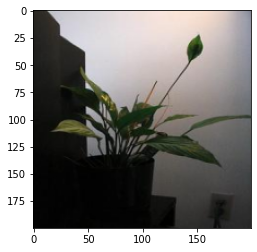

In [7]:
plt.imshow(images[1]/255)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


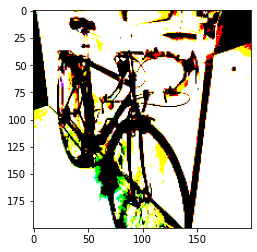

In [8]:
plt.imshow(A[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


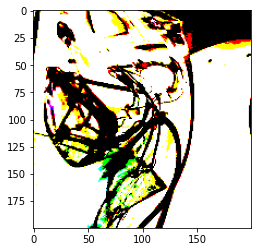

In [9]:
plt.imshow(B[1])

# 2. Model definition

In [10]:
from models.cnngeo import CNN_geotransform

In [11]:
# (a) feature extraction
vgg16 = tf.keras.applications.VGG16(weights='imagenet', input_shape=(input_size[0], input_size[1], 3), 
                                    include_top=False)
output_layer = vgg16.get_layer("block4_conv3")
output_layer.activation = None
feature_extractor = tf.keras.Model(inputs=vgg16.input, outputs=output_layer.output)

In [12]:
cnngeo = CNN_geotransform(feature_extractor, 18)

In [13]:
geo_parameters, correlations = cnngeo(A, B)

In [14]:
cnngeo.summary()

Model: "cnn_geotransform"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 25, 25, 512)       7635264   
_________________________________________________________________
correlation_network (Correla multiple                  0         
_________________________________________________________________
spatial_regressor (Spatial_r multiple                  4384978   
Total params: 12,020,242
Trainable params: 12,019,858
Non-trainable params: 384
_________________________________________________________________


In [15]:
geo_parameters.shape

TensorShape([10, 9, 2])

# 3.Training

In [16]:
def loss_fn(preds, labels):
    control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
    num_batch = preds.shape[0]
    pred_grid_x, pred_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), -preds, (20, 20))
    gt_grid_x, gt_grid_y = tps(tf.tile(control_points[tf.newaxis,::], [num_batch,1,1]), -labels, (20, 20))
    
    dist = tf.sqrt(tf.pow(pred_grid_x - gt_grid_x, 2) + tf.pow(pred_grid_y - gt_grid_y, 2))
    loss_mean = tf.reduce_mean(dist)
    return loss_mean


@tf.function
def train_step(image_A, image_B, labels, model, optimizer):
    with tf.GradientTape() as tape:
        preds, corr = model(image_A, image_B)
        loss = loss_fn(preds, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1E-4)

train_loss = tf.metrics.Mean(name='train_loss')
x_axis = []
y_loss = []
for epoch in range(4000):
    for step, (image_a, image_b, labels) in enumerate(ds):
        t_loss = train_step(image_a, image_b, labels, cnngeo, optimizer)
        train_loss(t_loss)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))
    x_axis.append(epoch)
    y_loss.append(train_loss.result().numpy())
    train_loss.reset_states()

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 7, Loss: 1.4453315734863281
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 17, Loss: 1.2000324726104736
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 27, Loss: 1.0729255676269531
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

Epoch 30, Loss: 1.0429679155349731
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 37, Loss: 0.9688464403152466
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 40, Loss: 0.9470407366752625
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 47, Loss: 0.8962864279747009
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 50, Loss: 0.871331512928009
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 57, Loss: 0.8366072773933411
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 60, Loss: 0.8093087673187256
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 67, Loss: 0.7873082756996155
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 70, Loss: 0.7780179381370544
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 77, L

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 80, Loss: 0.738651692867279
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 90, Loss: 0.7104227542877197
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 100, Loss: 0.6779509782791138
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 110, Loss: 0.6580791473388672
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 120, Loss: 0.6367502808570862
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 130, Loss: 0.6252696514129639
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 140, Loss: 0.6073740720748901
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 150, Loss: 0.5826820731163025
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 160, Loss: 0.5795912742614746
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 170, Loss: 0.5730148553848267
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 180, Loss: 0.5622200965881348
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 190, Loss: 0.5432778596878052
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 200, Loss: 0.5321907997131348
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 210, Loss: 0.5368377566337585
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 220, Loss: 0.5256154537200928
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 230, Loss: 0.5260921716690063
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 240, Loss: 0.5092740058898926
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 250, Loss: 0.5012749433517456
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 260, Loss: 0.4954013526439667
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

Epoch 263, Loss: 0.49026307463645935
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200,

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 270, Loss: 0.4911193251609802
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 273, Loss: 0.4891412854194641
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 280, Loss: 0.47912654280662537
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 283, Loss: 0.4846115708351135
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 290, Loss: 0.48039087653160095
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 293, Loss: 0.4772781431674957
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 300, Loss: 0.4686678946018219
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 303, Loss: 0.4683135151863098
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 310, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 313, Loss: 0.4667169153690338
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 323, Loss: 0.45791760087013245
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 333, Loss: 0.45132771134376526
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 343, Loss: 0.45045045018196106
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 353, Loss: 0.44931560754776
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 363, Loss: 0.4435253441333771
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 373, Loss: 0.4446090757846832
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 383, Loss: 0.43252018094062805
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 393, Loss: 0.43378597497940063
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 403, Loss: 0.4251215159893036
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 413, Loss: 0.4219401776790619
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 423, Loss: 0.41499608755111694
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 433, Loss: 0.4210899770259857
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 443, Loss: 0.42047587037086487
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 453, Loss: 0.41451314091682434
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 463, Loss: 0.42041459679603577
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 473, Loss: 0.40592753887176514
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 483, Loss: 0.4101870357990265
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 493, Loss: 0.40322279930114746
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

Epoch 496, Loss: 0.40125569701194763
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200,

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 503, Loss: 0.400652140378952
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 20

(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 506, Loss: 0.40331804752349854
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 513, Loss: 0.4002242386341095
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 516, Loss: 0.3963058590888977
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 523, Loss: 0.39395642280578613
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 526, Loss: 0.3989436626434326
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 533, Loss: 0.3912675678730011
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 536, Loss: 0.38958510756492615
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 543, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 546, Loss: 0.38455554842948914
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 556, Loss: 0.3863086402416229
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 566, Loss: 0.3863246440887451
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 576, Loss: 0.3828592300415039
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 

(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(5, 200, 200, 3)
Epoch 586, Loss: 0.3836270868778229
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 200, 3)
(10, 200, 2

In [ ]:
fig = plt.figure()
axis = fig.add_subplot(111)
axis.title.set_text("training_loss")
axis.set_xlabel("epoch")
axis.set_ylabel("training loss")
axis.plot(np.array(x_axis), np.array(y_loss))

In [ ]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds, corr = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

In [ ]:
def restore_original_image_from_array(x, data_format=None):
    mean = [103.939, 116.779, 123.68]

    # Zero-center by mean pixel
    if data_format == 'channels_first':
        if x.ndim == 3:
            x[0, :, :] += mean[0]
            x[1, :, :] += mean[1]
            x[2, :, :] += mean[2]
        else:
            x[:, 0, :, :] += mean[0]
            x[:, 1, :, :] += mean[1]
            x[:, 2, :, :] += mean[2]
    else:
        x[..., 0] += mean[0]
        x[..., 1] += mean[1]
        x[..., 2] += mean[2]

    if data_format == 'channels_first':
        # 'BGR'->'RGB'
        if x.ndim == 3:
            x = x[::-1, ...]
        else:
            x = x[:, ::-1, ...]
    else:
        # 'BGR'->'RGB'
        x = x[..., ::-1]

    return x

In [ ]:
plt.imshow(A[1])

In [ ]:
plt.imshow(B[1])

In [ ]:
plt.imshow(warping_images[4])

In [ ]:
plt.imshow(restore_original_image_from_array(B[1].numpy())/255)

In [ ]:
plt.imshow(restore_original_image_from_array(warping_images[1])/255)

In [ ]:
plt.imshow(images[1]/255)

# Comparison between ground-truth and prediction of motion vectors.

In [ ]:
print(p.shape)
print(preds.shape)

In [ ]:
for A, B, p in ds.take(1):
    print(A.shape, B.shape)
    preds, corr = cnngeo(A, B)

warping_images = []
output_size = A.shape[1:3]
control_points = tf.constant([[-1.0, -1.0], [0.0, -1.0], [1.0, -1.0],
                               [-1.0, 0.0], [0.0, 0.0], [1.0, 0.0],
                               [-1.0, 1.0], [0.0, 1.0], [1.0, 1.0]], dtype=tf.float32)
for image, pred in zip(A, preds):
    x_s, y_s = tps(control_points[tf.newaxis,::], -pred[tf.newaxis,::], output_size)
    image = image.numpy()
    warping_images.append(cv2.remap(image, x_s[0].numpy(), y_s[0].numpy(), cv2.INTER_CUBIC))

warping_images = np.array(warping_images)    

In [ ]:
def decode(x):
    x = (x + 1)/2
    if type(x) != np.ndarray:
        return x.numpy()
    else:
        return x
def makeBorder(image, bordersize):
    draw_image = image.copy()
    color = [1, 1, 1]
    draw_image = cv2.copyMakeBorder(draw_image,
                                    top=bordersize, bottom=bordersize,
                                    left=bordersize, right=bordersize,
                                    borderType=cv2.BORDER_CONSTANT,
                                    value=color)
    return draw_image


def draw_point(image, bordersize, points=None):
    draw_image = image.copy()
    H, W, C = draw_image.shape
    if points is None:
        points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                           [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                           [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    points = points * (W - 2 * bordersize, H - 2 * bordersize)
    points = points.astype(np.int32)
    for pnt in points:
        draw_image = cv2.circle(draw_image, tuple(
            pnt + bordersize), 1, (0, 1, 0), -1)
    return draw_image


def draw_arrow(image, bordersize, motion_parameters, src_points=None):
    draw_image = image.copy()
    H, W, C = image.shape
    if src_points is None:
        src_points = np.array([[0.0, 0.0], [0.5, 0.0], [1.0, 0.0],
                               [0.0, 0.5], [0.5, 0.5], [1.0, 0.5],
                               [0.0, 1.0], [0.5, 1.0], [1.0, 1.0]])
    src_points = src_points * (W - 2 * bordersize, H - 2 * bordersize)
    src_points = src_points.astype(np.int32)
    motion_parameters = motion_parameters * \
        (W - 2 * bordersize, H - 2 * bordersize)
    dst_points = src_points + motion_parameters
    dst_points = dst_points.astype(np.int32)

    for src, dst in zip(src_points, dst_points):
        draw_image = cv2.arrowedLine(draw_image, tuple(src + bordersize), tuple(dst + bordersize),
                                     (1, 0, 0), 1)
    return draw_image

In [ ]:
motion_vector = p[0].numpy()

padd = 50
white_board = makeBorder(A[0].numpy(), padd)

In [ ]:
plt.imshow(draw_point(white_board, padd))

In [ ]:
plt.imshow(draw_arrow(white_board, padd, p[0].numpy()/2))

In [ ]:
plt.imshow(B[0].numpy())

In [ ]:
plt.imshow(draw_arrow(white_board, padd, preds[0].numpy()/2))

In [ ]:
plt.imshow(warping_images[0])

In [ ]:
cnngeo.save_weights("cnngeo.h5")